In [1]:
# Base libraries
import os
# Scientific libraries
import numpy as np
import pandas as pd
import random
import movecolumn as mc
from collections import Counter
from datetime import datetime, timedelta
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
from tqdm import tqdm
# Visual libraries
import matplotlib.pyplot as plt
# from matplotlib import rcParams
import seaborn as sns

# from qbstyles import mpl_style
# mpl_style(dark=True)
import mplcyberpunk
plt.style.use("cyberpunk")

# Helper libraries
import itertools
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
import copy

from tqdm import tqdm
tqdm.pandas(desc="bar")

warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
from catboost import CatBoostClassifier, Pool
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost  import CatBoostClassifier , Pool

In [3]:
from sklearn.model_selection import train_test_split
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)
import pymorphy2

---
# Загрузка данных и конфигов

In [4]:
PATH = './data/'
payments_main = pd.read_csv(PATH + 'payments_main.tsv', sep="\t", header=None)
# Указать заголовки вручную (пример заголовков, замените на актуальные)
payments_main.columns = ['id', 'date', 'sum', 'describe']

print(payments_main.shape)
payments_main.head(20)

(25000, 4)


,id,date,sum,describe
0,1,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г
1,2,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...
2,3,07.11.2024,4710-00,Оплата штрафа
3,4,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025
4,5,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...
5,6,07.11.2024,4210.00,Оплата за Бульон Роллтон Домашний куриный 90г ...
6,7,07.11.2024,4240-00,Комиссионное вознаграждение за валютный перевод.
7,8,07.11.2024,4630.00,государственная пошлина
8,9,07.11.2024,8000.00,Лечение по договору №Д00184/63 от 27.12.2023 г.
9,10,07.11.2024,"1310000,00","Оплата по счету 0187,0188,0189 от 02.01.2024 (..."


In [5]:
payments_training = pd.read_csv(PATH + 'payments_training.tsv', sep="\t", header=None)
payments_training.columns = ['id', 'date', 'sum', 'describe','label']
print(payments_training.shape)
payments_training.head(20)

(500, 5)


,id,date,sum,describe,label
0,1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,SERVICE
1,2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,SERVICE
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,LOAN
4,5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED
5,6,07.11.2024,"1820000,00",Оплата по дог.финансовой аренды №Б00358 от 30....,LEASING
6,7,07.11.2024,"4900,00",Оплата за Мицеллярная вода Чистая Линия Цветоч...,NON_FOOD_GOODS
7,8,07.11.2024,"3250,00",Оплата за Стиральные порошки по счету 19434127...,NON_FOOD_GOODS
8,9,07.11.2024,"5000,00",Оплата по договору №Е01368 от 03 августа 2027г...,FOOD_GOODS
9,10,07.11.2024,1840000.00,Оплата по договору процентного займа б/н от 21...,LOAN


In [16]:
YndexGPT_labeled = pd.read_parquet(PATH + "YndexGPT_labeled.parquet")
YndexGPT_labeled = YndexGPT_labeled[YndexGPT_labeled['prob'] > 0.8]
YndexGPT_labeled.reset_index(drop=True, inplace=True)
print(YndexGPT_labeled.shape)
YndexGPT_labeled.head(20)

(22867, 3)


,describe,pred_label,prob
0,Оплата за Дезодорант Seasons для обуви 100мл п...,NON_FOOD_GOODS,0.989704
1,"оплата по счетам 0704, 0704,0811, 0708 за услу...",SERVICE,0.999822
2,Оплата за Груши Конференция по счету 114383178...,FOOD_GOODS,0.999598
3,Оплата по товарой накладной за 100 штук пачек ...,NON_FOOD_GOODS,0.932440
4,Оплата по договору процентного займа №04372Б о...,LOAN,0.999962
5,Оплата по договору процентного займа №В02442 о...,LOAN,0.999937
6,Оплата за Минтай Borealis филе блочное без кож...,FOOD_GOODS,0.998522
7,Оплата за Полотенца бумажные Tolli Plus 2 слоя...,NON_FOOD_GOODS,0.995879
8,Комиссия за платежи в валюте Российской Федера...,BANK_SERVICE,0.982188
9,Оплата за кофе в зернах по счету 2188939510596...,NON_FOOD_GOODS,0.956242


In [17]:
payments_training['label'].value_counts()

label
NON_FOOD_GOODS    96
FOOD_GOODS        90
SERVICE           88
BANK_SERVICE      49
TAX               48
LOAN              41
LEASING           38
REALE_STATE       27
NOT_CLASSIFIED    23
Name: count, dtype: int64

In [18]:
morph_vocab = MorphVocab()

# Словарь для конвертации из тегов OpenCorpora, которые использует pymorphy, в Universal Tags
OC_UD_POS = {
    'ADJF': 'ADJ', # Прилагательное
    'ADJS': 'ADJ', # Прилагательное

    'ADVB': 'ADV', # Наречие
    'COMP': 'ADV', # Компаратив

    'VERB': 'VERB', # Глагол
    'GRND': 'VERB', # Деепричастие
    'INFN': 'VERB', # Инфинитив
    'PRTF': 'VERB', # Причастие
    'PRTS': 'VERB', # Причастие

    'NOUN': 'NOUN', # Существительное
    'NPRO': 'PRON', # Местоимение-существительное - удаляем

    'NUMR': 'NUM', # Числительное
    'NUMB': 'NUM', # Числительное

    'Apro': 'DET', # 'местоименное', сюда попадает дичь - удаляем
    'CONJ': 'CCONJ', # Союз - удаляем
    'INTJ': 'INTJ', # Междометие, слова типа "ай", "ой" + наташа складывает сюда всякую срань - удаляем
    'PART': 'PRCL', # Частица, вроде не используется - удаляем
    'PNCT': 'PUNCT', # Пунктуация
    'PRCL': 'PART', # Частица - удаляем
    'PREP': 'ADP', # Предлог adposition - удаляем
}

# Теги частей речи, которые будем исключать
STOP_TAGS = ['PRON','DET','CCONJ','INTJ','PRCL','ADP']

def lemmatize_text_Natasha_pm(text, 
                              segmenter=Segmenter(), 
                              morph_tagger=NewsMorphTagger(NewsEmbedding()),
                              morph_vocab=MorphVocab(), 
                              pyMorphyMorphAnalyser=pymorphy2.MorphAnalyzer(),
                              stopwords=[],
                              exclude_punctuation=True):
    #Подгружаем документ
    text = ' '.join(text.split('-'))
    text = ' '.join(i for i in text.split() if len(i)>1)
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    uni_tags = []
    
    for token in doc.tokens:
        # Доступные формы в pymorphy
        pm_phorms = [x for x in pyMorphyMorphAnalyser.parse(token.text) ]
        # Теги всех форм в universal формате и варианте Natasha
        tags = [[str(x.tag).split(',')[0].split(' ')[0],OC_UD_POS[str(x.tag).split(',')[0].split(' ')[0]],x.normal_form] 
                if str(x.tag).split(',')[0].split(' ')[0] in OC_UD_POS.keys() 
                else [str(x.tag).split(',')[0].split(' ')[0],None,x.normal_form]
                for x in pm_phorms]
        # Проверяем, может ли слово иметь часть речи, определённую Natasha
        same_tags = [x for x in tags if x[1]==token.pos]
        if same_tags:
            uni_tags.append(same_tags[0][0])
        # Если не может
        elif tags and token.pos not in tags:
            # Проверяем наличие вариантов с тегами из обеих либ
            n_tags = [x for x in tags if x[1] is not None]
            if n_tags:
                uni_tags.append(n_tags[0][0])
                token.pos = n_tags[0][1]
            # Если таких нет, оставляем тег Natasha, в качестве universasl добавляем определённый pymorphy
            else:
                uni_tags.append(tags[0][0])
        # Лемматизируем с учётом проверенных тегов
        token.lemmatize(morph_vocab)
            
    
    # display(doc.tokens)
    
    tokens = [t for t in doc.tokens if (t.pos!='PUNCT' or not exclude_punctuation) and t.lemma not in stopwords and t.pos not in STOP_TAGS]
    # исходный текст
    unprocessed_text = ' '.join([t.text.lower() for t in tokens])
    # текст в леммах
    lemmed_text = ' '.join([t.lemma for t in tokens])
    # текст в леммах с тегами universal
    lemmed_text_with_uni_tags = ' '.join([t.lemma+'_'+t.pos for t in tokens])
    # текст в леммах с тегами OpenCorpora
    lemmed_text_with_OC_tags = ' '.join([t.lemma+'_'+ut for t,ut in zip(doc.tokens,uni_tags) if (t.pos!='PUNCT' or not exclude_punctuation) and t.lemma not in stopwords and t.pos not in STOP_TAGS])
    return unprocessed_text,lemmed_text,lemmed_text_with_uni_tags,lemmed_text_with_OC_tags

# проверка отработки
print(lemmatize_text_Natasha_pm('Мама не мыла раму ТК-79 u')[1])

мама не мыть рама тк 79


In [19]:
import re
import string
from nltk.corpus import stopwords

# Загружаем список стоп-слов
import nltk
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

# Список названий месяцев
months = [
    "январь", "февраль", "март", "апрель", "май", "июнь", 
    "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь",
    "января", "февраля", "марта", "апреля", "мая", "июня", 
    "июля", "августа", "сентября", "октября", "ноября", "декабря"
]

def preprocess_text(text):
    # Проверяем, является ли значение строкой
    if isinstance(text, str):
        # 1. Переводим текст в нижний регистр
        text = text.lower()
        
        # 2. Удаляем все интернет-ссылки
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # 3. Удаляем почтовые адреса
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', text)

        # 2. Удаляем все цифры
        text = re.sub(r'\d+', '', text)
        
        # 3. Удаляем символы, включая № и прочие специальные знаки
        text = re.sub(r'[^\w\s]', ' ', text)  # Оставляем только буквы, цифры и пробелы
        
        # 4. Удаляем лишние пробелы
        text = re.sub(r'\s+', ' ', text).strip()
        
        # 5. Удаляем префиксы FW, RE, Re в начале строки (case insensitive)
        text = re.sub(r'^(fw|re|re:)', '', text, flags=re.IGNORECASE).strip()

        # 6. Удаляем одиночные буквы
        text = re.sub(r'\b\w\b', '', text)  # Удаляем одиночные символы

        # 7. Удаляем названия месяцев
        for month in months:
            text = re.sub(rf'\b{month}\b', '', text)  # Удаляем месяцы целиком (слово)

        # 8. Удаляем все слова, не состоящие из кириллических символов
        text = ' '.join([word for word in text.split() if re.match(r'^[а-яё]+$', word)])

        # 9. Удаляем лишние пробелы ещё раз
        text = re.sub(r'\s+', ' ', text).strip()

        # 10. Удаляем стоп-слова
        words = text.split()
        words = [word for word in words if word not in russian_stopwords]

        # 11. Объединяем текст обратно
        cleaned_text = ' '.join(words)

        # 12. Заменяем слова "гос" или "гос." на "государственный"
        cleaned_text = re.sub(r'\bгос\.?\b', 'государственный', cleaned_text)

        # 13. Заменяем слова "дог" или "дог." на "договор"
        cleaned_text = re.sub(r'\bдог\.?\b', 'договор', cleaned_text)
        
        return cleaned_text
    else:
        # Возвращаем исходное значение, если это не строка
        return text


[nltk_data] Downloading package stopwords to /home/den/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
payments_training['lemmed_opisanie'] = payments_training['describe'].fillna('<Nan>').progress_apply(lambda x: lemmatize_text_Natasha_pm(x)[1] if len(x)>0 else '<Nan>')
payments_training['lemmed_opisanie'] = payments_training['lemmed_opisanie'].apply(preprocess_text)
payments_training['sum'] = payments_training['sum'].str.replace(',', '').str.replace('-', '').apply(lambda x: float(x) if '.' in x else int(x))

payments_main['lemmed_opisanie'] = payments_main['describe'].fillna('<Nan>').progress_apply(lambda x: lemmatize_text_Natasha_pm(x)[1] if len(x)>0 else '<Nan>')
payments_main['lemmed_opisanie'] = payments_main['lemmed_opisanie'].apply(preprocess_text)
payments_main['sum'] = payments_main['sum'].str.replace(',', '').str.replace('-', '').apply(lambda x: float(x) if '.' in x else int(x))

bar: 100%|██████████| 25000/25000 [02:22<00:00, 175.16it/s]


In [27]:
YndexGPT_labeled = YndexGPT_labeled[["describe", "pred_label"]]
YndexGPT_labeled['lemmed_opisanie'] = YndexGPT_labeled['describe'].fillna('<Nan>').progress_apply(lambda x: lemmatize_text_Natasha_pm(x)[1] if len(x)>0 else '<Nan>')
YndexGPT_labeled['lemmed_opisanie'] = YndexGPT_labeled['lemmed_opisanie'].apply(preprocess_text)
YndexGPT_labeled = YndexGPT_labeled.drop_duplicates('lemmed_opisanie')
YndexGPT_labeled.reset_index(drop=True, inplace=True)
YndexGPT_labeled

bar: 100%|██████████| 3190/3190 [00:19<00:00, 163.40it/s]


,describe,pred_label,lemmed_opisanie
0,Оплата за Дезодорант Seasons для обуви 100мл п...,NON_FOOD_GOODS,оплата дезодорант обувь мл счет сумма
1,"оплата по счетам 0704, 0704,0811, 0708 за услу...",SERVICE,оплата счет услугисумма ндс
2,Оплата за Груши Конференция по счету 114383178...,FOOD_GOODS,оплата груша конференция счет сумма
3,Оплата по товарой накладной за 100 штук пачек ...,NON_FOOD_GOODS,оплата товарой накладная штука пачка кофе счет...
4,Оплата по договору процентного займа №04372Б о...,LOAN,оплата договор процентный заем ндс
...,...,...,...
3185,"Приобретение недвижимости по адресу г. Мытищи,...",REALE_STATE,приобретение недвижимость адрес мытищи парковы...
3186,"За транспортировку, перевозка водным транспорт...",SERVICE,транспортировка перевозка водный транспорт анг...
3187,"Приобретение недвижимости по адресу г. Елец, М...",REALE_STATE,приобретение недвижимость адрес елец мир ул до...
3188,За покупку авиабилетов г. Ангарск - г. Таганро...,SERVICE,покупка авиабилет ангарск таганрог договор


In [28]:
payments_training['sum'] = payments_training['sum'].astype(int)

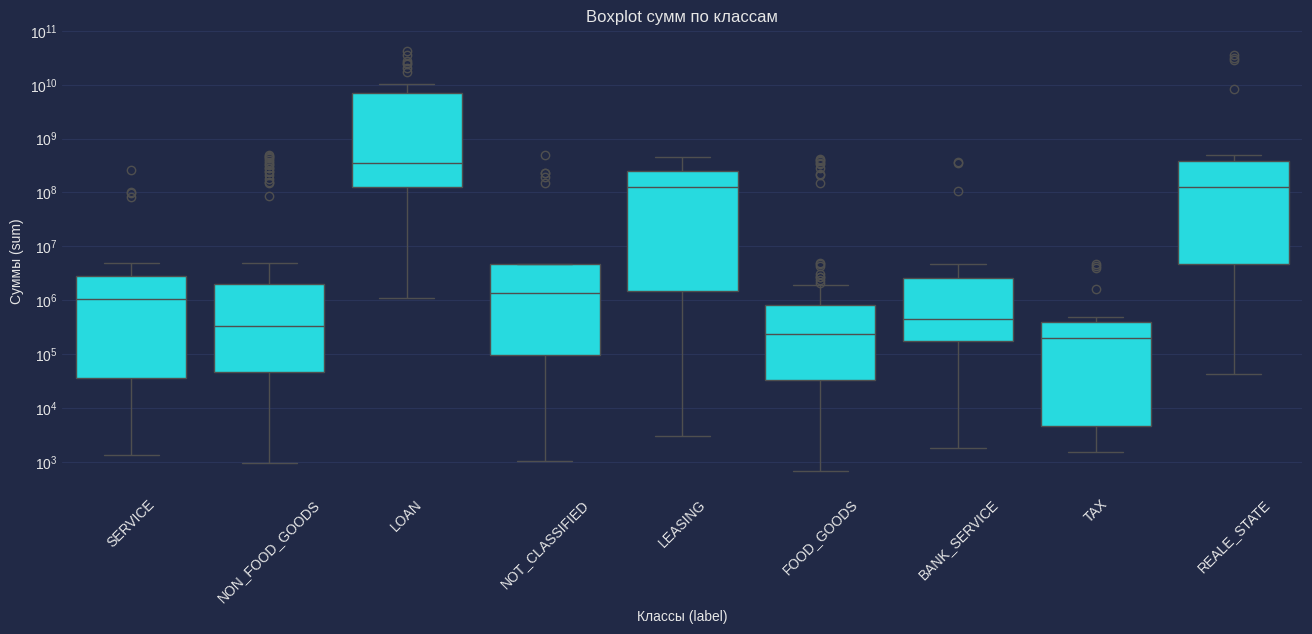

Есть статистически значимые различия между классами (p = 0.00000).


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Построение boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(data=payments_training, x='label', y='sum')
plt.title('Boxplot сумм по классам')
plt.xlabel('Классы (label)')
plt.ylabel('Суммы (sum)')
plt.xticks(rotation=45)  # Для улучшения читаемости, если классов много
plt.yscale('log')  # Устанавливаем логарифмическую шкалу для оси y
plt.show()

# Проверка на стат. значимость
groups = [payments_training[payments_training['label'] == cls]['sum'] for cls in payments_training['label'].unique()]
stat, p = kruskal(*groups)

if p < 0.05:
    print(f"Есть статистически значимые различия между классами (p = {p:.5f}).")
else:
    print(f"Нет статистически значимых различий между классами (p = {p:.5f}).")

In [12]:
from optbinning import MulticlassOptimalBinning

variable = 'sum'
optb = MulticlassOptimalBinning(name=variable, solver="cp")
optb.fit(payments_training['sum'], payments_training['label'])

binning_table = optb.binning_table
binning_table.build()

(CVXPY) Nov 16 07:16:59 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 16 07:16:59 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


,Bin,Count,Count (%),Event_BANK_SERVICE,Event_FOOD_GOODS,Event_LEASING,Event_LOAN,Event_NON_FOOD_GOODS,Event_NOT_CLASSIFIED,Event_REALE_STATE,...,Event_TAX,Event_rate_BANK_SERVICE,Event_rate_FOOD_GOODS,Event_rate_LEASING,Event_rate_LOAN,Event_rate_NON_FOOD_GOODS,Event_rate_NOT_CLASSIFIED,Event_rate_REALE_STATE,Event_rate_SERVICE,Event_rate_TAX
0,"(-inf, 1595000.00)",295,0.59,33,70,11,2,72,12,2,...,45,0.111864,0.237288,0.037288,0.006780,0.244068,0.040678,0.006780,0.162712,0.152542
1,"[1595000.00, inf)",205,0.41,16,20,27,39,24,11,25,...,3,0.078049,0.097561,0.131707,0.190244,0.117073,0.053659,0.121951,0.195122,0.014634
2,Special,0,0.00,0,0,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Missing,0,0.00,0,0,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Totals,,500,1.00,49,90,38,41,96,23,27,...,48,0.098000,0.180000,0.076000,0.082000,0.192000,0.046000,0.054000,0.176000,0.096000


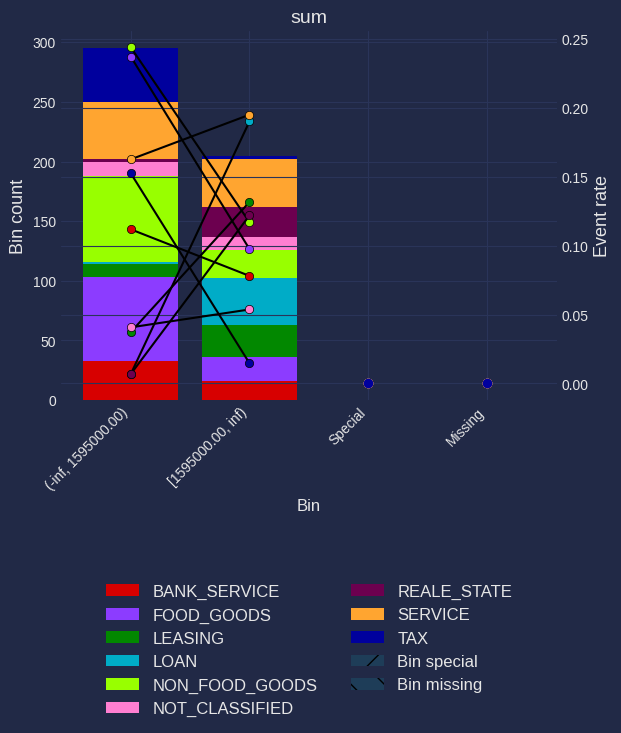

In [13]:
binning_table.plot(show_bin_labels=True)

In [14]:
optb.transform(payments_training['sum'], metric="bins")

array(['(-inf, 1595000.00)', '[1595000.00, inf)', '(-inf, 1595000.00)',
       '[1595000.00, inf)', '(-inf, 1595000.00)', '[1595000.00, inf)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '(-inf, 1595000.00)',
       '[1595000.00, inf)', '[1595000.00, inf)', '[1595000.00, inf)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '[1595000.00, inf)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '(-inf, 1595000.00)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '(-inf, 1595000.00)',
       '(-inf, 1595000.00)', '[1595000.00, inf)', '(-inf, 1595000.00)',
       '[1595000.00, inf)', '[1595000.00, inf)', '(-inf, 1595000.00)',
       '(-inf, 1595000.00)', '[1595000.00, inf)', '[1595000.00, inf)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '(-inf, 1595000.00)',
       '(-inf, 1595000.00)', '(-inf, 1595000.00)', '(-inf, 1595000.00)',
       '[1595000.00, inf)', '[1595000.00, inf)', '[1595000.00, inf)',
       '[1595000.00, inf)', '(-inf, 1595000.00)', '(-inf, 1595000.

In [15]:
optb.splits

array([1595000.])

In [16]:
print(payments_training.shape)
print(payments_main.shape)
payments_training.head(20)

(500, 6)
(25000, 5)


,id,date,sum,describe,label,lemmed_opisanie
0,1,07.11.2024,15300,За участие в конференции в г. Майкоп по догово...,SERVICE,участие конференция майкоп договор дв
1,2,07.11.2024,4020000,За оказание услуг по договору №79-02726В от 01...,SERVICE,оказание услуга договор
2,3,07.11.2024,144000,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS,оплата порошок стиральный кг счет сумма
3,4,07.11.2024,24000000000,Возврат денежных средств по договору займа №04...,LOAN,возврат денежный средство договор заем ндс
4,5,07.11.2024,1360000,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED,оплата договор согл сч оплата сброс загрязнять...
5,6,07.11.2024,182000000,Оплата по дог.финансовой аренды №Б00358 от 30....,LEASING,оплата договор финансовый аренда акт прием пер...
6,7,07.11.2024,490000,Оплата за Мицеллярная вода Чистая Линия Цветоч...,NON_FOOD_GOODS,оплата мицеллярный вода чистый линия цветочный...
7,8,07.11.2024,325000,Оплата за Стиральные порошки по счету 19434127...,NON_FOOD_GOODS,оплата стиральный порошок счет сумма
8,9,07.11.2024,500000,Оплата по договору №Е01368 от 03 августа 2027г...,FOOD_GOODS,оплата договор счет мясной деликатес сумма ндс
9,10,07.11.2024,1840000,Оплата по договору процентного займа б/н от 21...,LOAN,оплата договор процентный заем ндс


In [17]:
payments_training.to_excel(PATH+'payments_training.xlsx')
print('датасет сохранен ...')

датасет сохранен ...


---
# TRAIN DATA

In [33]:
X_train_full = payments_training['lemmed_opisanie']
y_train_full = payments_training['label']

X_test = payments_main['lemmed_opisanie']

X_train_full = pd.DataFrame(X_train_full)
X_test = pd.DataFrame(X_test)

print(X_train_full.shape , X_test.shape , y_train_full.shape )
X_train_full.head()

(500, 1) (25000, 1) (500,)


,lemmed_opisanie
0,участие конференция майкоп договор дв
1,оказание услуга договор
2,оплата порошок стиральный кг счет сумма
3,возврат денежный средство договор заем ндс
4,оплата договор согл сч оплата сброс загрязнять...


In [19]:
from sklearn import preprocessing

le_target = preprocessing.LabelEncoder()
y_train = le_target.fit_transform(y_train_full)

print(y_train.shape)
y_train

(500,)


array([7, 7, 4, 3, 5, 2, 4, 4, 1, 3, 3, 0, 7, 7, 3, 7, 1, 4, 8, 4, 2, 8,
       1, 7, 1, 2, 2, 1, 4, 1, 4, 7, 1, 7, 4, 0, 1, 1, 0, 2, 4, 8, 7, 1,
       4, 4, 0, 4, 2, 4, 7, 1, 1, 4, 1, 4, 1, 8, 4, 4, 1, 5, 7, 3, 1, 4,
       1, 8, 3, 0, 1, 7, 1, 4, 7, 1, 5, 8, 7, 6, 4, 0, 2, 1, 7, 7, 6, 5,
       8, 1, 4, 2, 7, 4, 7, 4, 3, 7, 4, 1, 6, 2, 7, 1, 4, 4, 7, 8, 2, 8,
       7, 7, 1, 4, 0, 0, 4, 4, 2, 8, 5, 7, 5, 1, 3, 0, 1, 1, 8, 8, 0, 1,
       3, 4, 5, 1, 7, 0, 0, 0, 3, 1, 0, 1, 3, 3, 1, 4, 4, 7, 1, 7, 0, 2,
       6, 5, 1, 1, 0, 4, 4, 4, 7, 2, 1, 7, 2, 3, 7, 8, 1, 4, 7, 5, 7, 4,
       4, 2, 3, 7, 8, 8, 2, 8, 0, 4, 7, 0, 2, 4, 3, 3, 0, 7, 4, 3, 6, 0,
       4, 2, 6, 7, 7, 4, 2, 1, 1, 1, 4, 7, 0, 4, 2, 1, 1, 2, 7, 6, 7, 6,
       1, 1, 4, 0, 3, 5, 0, 4, 1, 2, 2, 6, 1, 4, 4, 3, 0, 1, 7, 4, 7, 4,
       3, 7, 4, 3, 6, 8, 8, 0, 3, 5, 7, 0, 5, 8, 1, 7, 1, 4, 7, 7, 8, 4,
       4, 2, 3, 6, 8, 4, 4, 4, 7, 4, 4, 1, 1, 4, 7, 5, 4, 6, 8, 5, 4, 6,
       5, 1, 7, 6, 4, 4, 0, 4, 5, 4, 4, 5, 3, 0, 7,

In [20]:
# Создаем словарь, где ключи - закодированные значения, а значения - оригинальные классы
label_dict = {encoded_label: original_label for encoded_label, original_label in zip(le_target.transform(le_target.classes_), le_target.classes_)}
label_dict

{0: 'BANK_SERVICE',
 1: 'FOOD_GOODS',
 2: 'LEASING',
 3: 'LOAN',
 4: 'NON_FOOD_GOODS',
 5: 'NOT_CLASSIFIED',
 6: 'REALE_STATE',
 7: 'SERVICE',
 8: 'TAX'}

---
# StratifiedKFold на Train датасете

In [21]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Stratified K-Fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Параметры модели
catboost_params = {
    'iterations': 5_000,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'verbose': False,
    # 'task_type': 'GPU',
    'random_seed': 42
}

# Текущие колонки
text_cols = ['lemmed_opisanie']
embedding_features = []
categorical_cols = []

# Заранее выделить тестовую выборку
X_tr, X_oof, y_tr, y_oof = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Результаты для всех итераций
y_true_all = []
y_pred_all = []

# Stratified K-Fold для train и val
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_tr, y_tr):
    X_train_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
    y_train_fold, y_val_fold = y_tr.iloc[train_idx], y_tr.iloc[val_idx]

    # Создание пулов для CatBoost
    train_pool = Pool(
        X_train_fold, 
        y_train_fold, 
        cat_features=categorical_cols,
        text_features=text_cols
    )
    valid_pool = Pool(
        X_val_fold, 
        y_val_fold, 
        cat_features=categorical_cols,
        text_features=text_cols
    )

    # Инициализация и обучение модели
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=valid_pool)

    # Предсказания на валидационной выборке
    y_pred_val = model.predict(X_val_fold)
    print(f'Fold Acc (val): {accuracy_score(y_val_fold, y_pred_val)}')

    # Сохранение результатов для валидации
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_val)

# Предсказания на тестовой выборке
y_pred_test = model.predict(X_oof)

# Метрика на тестовой выборке
test_accuracy = accuracy_score(y_oof, y_pred_test)
print(f'Test Accuracy: {test_accuracy}')

Fold Acc (val): 0.8805970149253731
Fold Acc (val): 0.8421052631578947
Fold Acc (val): 0.8947368421052632
Test Accuracy: 0.89


Stratified CV Accuracy: 0.8900


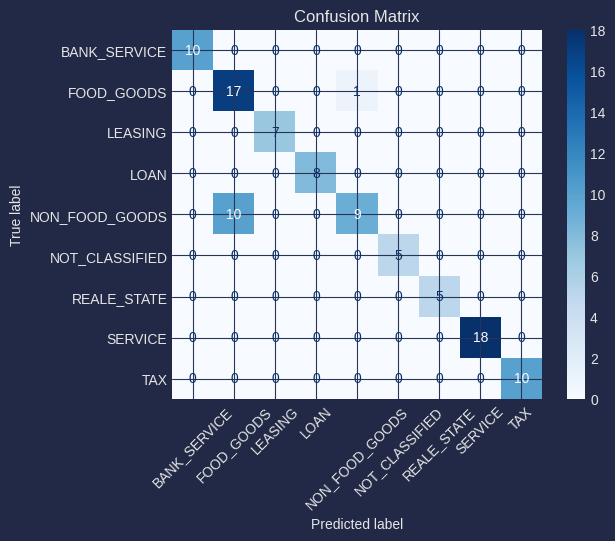

In [22]:
# Оценка Accuracy
accuracy = accuracy_score(y_oof, y_pred_test)
print(f"Stratified CV Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_oof, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

---
# Pseudo lebling

In [23]:
# Параметры модели
catboost_params = {
    'iterations': 5_000,
    'learning_rate':0.01,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 1000,
    'use_best_model': True,
    'verbose': False,
    # 'task_type': 'GPU',
    'random_seed': 42
}

# Текущие колонки
text_cols = ['lemmed_opisanie']
embedding_features = []
categorical_cols = []

# Создание пулов для CatBoost
train_pool = Pool(
    X_train_full, 
    y_train_full, 
    cat_features=categorical_cols,
    text_features=text_cols
)
valid_pool = Pool(
    X_train_full, 
    y_train_full, 
    cat_features=categorical_cols,
    text_features=text_cols
)

# Инициализация и обучение модели
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool , plot=True)

# Сохраняю результаты**********************************************
model.save_model('./models/catboost_model.cbm')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
print(model.best_iteration_)
print(model.best_score_)

1179
{'learn': {'Accuracy': 0.986, 'MultiClass': 0.13265451972695674}, 'validation': {'Accuracy': 0.978, 'MultiClass': 0.09511997480476433}}


In [25]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)
print(y_pred_proba_test.shape)

# Находим максимальное значение в каждой строке
max_values = np.max(y_pred_proba_test, axis=1)
# Получаем индексы строк, где максимальное значение больше 0.8
indices = np.where(max_values > 0.8)[0]
# Выбираем соответствующие строки
filtered_rows = y_pred_proba_test[indices]
y_pred_test_filtered = y_pred_test[indices]
y_pred_test_filtered = pd.Series(y_pred_test_filtered.flatten(), name="Predicted_Class")
print(filtered_rows.shape)

X_test_filtered = X_test.iloc[indices]
X_test_filtered.reset_index(drop=True,inplace=True)
y_pred_test_filtered.reset_index(drop=True,inplace=True)

# Результат: строки и их индексы
print("Индексы:", indices)
print("Строки:", filtered_rows)
print(X_test_filtered.shape)

(25000, 9)
(19740, 9)
Индексы: [    0     1     3 ... 24997 24998 24999]
Строки: [[0.0044835  0.0022422  0.00320471 ... 0.00574177 0.97072885 0.00496764]
 [0.00517018 0.0029672  0.00378289 ... 0.00618078 0.96529974 0.00551197]
 [0.00469706 0.00248709 0.00438834 ... 0.00603115 0.96848352 0.00488789]
 ...
 [0.80045925 0.00914266 0.0137074  ... 0.09990225 0.02389566 0.01332635]
 [0.00641374 0.00478666 0.0049426  ... 0.00617661 0.00798201 0.95473566]
 [0.00190116 0.84972813 0.00221628 ... 0.00216814 0.00209168 0.00243466]]
(19740, 1)


In [26]:
X_test.iloc[indices]

,lemmed_opisanie
0,тур поездка договор
1,оказание услуга договор
3,лечение договор далее
4,оплата основный долг период договор оао второй...
5,оплата бульон роллтон домашний куриный счет сумма
...,...
24995,оплата договор сырье пвадсумма ндс
24996,государственный услуга
24997,предоставление кредит договор далее приобретен...
24998,оплата государственный пошлина


In [27]:
# Сохранение в формате Parquet с сохранением индексов
X_test.iloc[indices].to_parquet('X_test_labled.parquet', index=True)

In [34]:
YndexGPT_labeled

,describe,pred_label,lemmed_opisanie
0,Оплата за Дезодорант Seasons для обуви 100мл п...,NON_FOOD_GOODS,оплата дезодорант обувь мл счет сумма
1,"оплата по счетам 0704, 0704,0811, 0708 за услу...",SERVICE,оплата счет услугисумма ндс
2,Оплата за Груши Конференция по счету 114383178...,FOOD_GOODS,оплата груша конференция счет сумма
3,Оплата по товарой накладной за 100 штук пачек ...,NON_FOOD_GOODS,оплата товарой накладная штука пачка кофе счет...
4,Оплата по договору процентного займа №04372Б о...,LOAN,оплата договор процентный заем ндс
...,...,...,...
3185,"Приобретение недвижимости по адресу г. Мытищи,...",REALE_STATE,приобретение недвижимость адрес мытищи парковы...
3186,"За транспортировку, перевозка водным транспорт...",SERVICE,транспортировка перевозка водный транспорт анг...
3187,"Приобретение недвижимости по адресу г. Елец, М...",REALE_STATE,приобретение недвижимость адрес елец мир ул до...
3188,За покупку авиабилетов г. Ангарск - г. Таганро...,SERVICE,покупка авиабилет ангарск таганрог договор


In [36]:
X_test_filtered = YndexGPT_labeled['lemmed_opisanie']
y_pred_test_filtered = YndexGPT_labeled['pred_label'] 

In [37]:
# Объединяем X_train_full и X_test_filtered по вертикали
X_combined = pd.concat([X_train_full, X_test_filtered], axis=0)
y_combined = pd.concat([y_train_full, y_pred_test_filtered], axis=0)
print(X_combined.shape ,y_combined.shape)

(3690, 1) (3690,)


In [45]:
index_true = X_combined.drop_duplicates('lemmed_opisanie').index
X_combined = X_combined.iloc[index_true]
y_combined = y_combined.iloc[index_true]

X_combined.reset_index(drop=True,inplace=True)
y_combined.reset_index(drop=True,inplace=True)

print(X_combined.shape ,y_combined.shape)
X_combined.head()

(3226, 1) (3226,)


,lemmed_opisanie
0,участие конференция майкоп договор дв
1,оказание услуга договор
2,оплата порошок стиральный кг счет сумма
3,возврат денежный средство договор заем ндс
4,оплата договор согл сч оплата сброс загрязнять...


---
# Сохранение полного датасета

In [47]:
# Сохранение в формате Parquet
X_combined.to_parquet(PATH + 'X_combined.parquet', index=False)
y_combined.to_frame(name='y_combined').to_parquet(PATH +'y_combined.parquet', index=False)

print("Датасеты успешно сохранены в формате Parquet.")

Датасеты успешно сохранены в формате Parquet.


In [48]:
PATH = './data/'
# Загрузка из формата Parquet
X_combined = pd.read_parquet(PATH+ 'X_combined.parquet')
y_combined = pd.read_parquet(PATH +'y_combined.parquet')['y_combined']

print(X_combined.shape ,y_combined.shape)
print("Датасеты успешно загружены из Parquet.")

(3226, 1) (3226,)
Датасеты успешно загружены из Parquet.


---
#

In [ ]:
# def train_with_multiple_splits_ensemble_multiclass(
#     X_train_full, 
#     y_train_full, 
#     n_splits=5, 
#     test_size=0.33, 
#     n_classes=9,
#     catboost_params=None, 
#     categorical_cols=None, 
#     text_cols=None,
#     random_state=42
# ):
#     """
#     Trains multiple CatBoost models and finds the best ensemble of three models with optimal weights
#     for multiclass classification.
#     """
    
#     if catboost_params is None:
#         catboost_params = {
#             'iterations': 5_000,
#             'learning_rate':0.01,
#             'eval_metric': 'Accuracy',
#             'early_stopping_rounds': 1000,
#             'use_best_model': True,
#             'verbose': False,
#             # 'task_type': 'GPU',
#             'random_seed': 42
#         }
    
#     # Удаляем use_best_model из параметров, если он есть
#     if 'use_best_model' in catboost_params:
#         catboost_params = catboost_params.copy()
#         del catboost_params['use_best_model']
    
#     # Списки для хранения результатов
#     all_models = []
#     all_oof_preds = []
#     all_oof_targets = []
    
#     # Для каждого разбиения
#     for split_idx in range(n_splits):
#         current_seed = random_state + split_idx
        
#         # Получаем случайную тестовую выборку
#         X_tr, X_oof, y_tr, y_oof = train_test_split(
#             X_train_full, 
#             y_train_full, 
#             test_size=test_size, 
#             stratify=y_train_full, 
#             random_state=current_seed
#         )
        
#         # Внутренняя кросс-валидация
#         skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=current_seed)
        
#         # Создаем пул для обучения
#         train_pool = Pool(
#             X_tr,
#             y_tr,
#             cat_features=categorical_cols,
#             text_features=text_cols
#         )
        
#         # Создаем пул для валидации
#         eval_pool = Pool(
#             X_oof,
#             y_oof,
#             cat_features=categorical_cols,
#             text_features=text_cols
#         )
        
#         # Обучаем модель
#         model = CatBoostClassifier(**catboost_params)
#         model.fit(
#             train_pool,
#             eval_set=eval_pool,
#             verbose=False
#         )
        
#         # Сохраняем модель и её предсказания
#         all_models.append(model)
#         all_oof_preds.append(model.predict_proba(X_oof))
#         all_oof_targets.append(y_oof)
        
#         # Выводим индивидуальную точность модели
#         y_pred_test = model.predict(X_oof)
#         current_accuracy = accuracy_score(y_oof, y_pred_test)
#         print(f'Split {split_idx + 1} Individual Accuracy: {current_accuracy:.4f}')

#     # Функция для оптимизации весов ансамбля
#     def ensemble_accuracy(weights, probs_list, true_values, models_idx):
#         weights = weights / np.sum(weights)
#         all_accuracies = []
        
#         for split_idx in range(len(probs_list)):
#             ensemble_probs = np.zeros_like(probs_list[split_idx])
#             weight_sum = 0
            
#             for idx, model_idx in enumerate(models_idx):
#                 if model_idx != split_idx:
#                     ensemble_probs += weights[idx] * probs_list[model_idx]
#                     weight_sum += weights[idx]
            
#             ensemble_probs = ensemble_probs / weight_sum
#             ensemble_preds = np.argmax(ensemble_probs, axis=1)
            
#             acc = accuracy_score(true_values[split_idx], ensemble_preds)
#             all_accuracies.append(acc)
        
#         return -np.mean(all_accuracies)

#     # Находим лучшую комбинацию из трех моделей
#     best_ensemble_accuracy = -np.inf
#     best_models_idx = None
#     best_weights = None
    
#     for models_idx in combinations(range(n_splits), 3):
#         initial_weights = np.ones(3) / 3
#         bounds = [(0, 1)] * 3
#         constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        
#         result = minimize(
#             ensemble_accuracy,
#             initial_weights,
#             args=(all_oof_preds, all_oof_targets, models_idx),
#             bounds=bounds,
#             constraints=constraints,
#             method='SLSQP'
#         )
        
#         ensemble_acc = -result.fun
        
#         if ensemble_acc > best_ensemble_accuracy:
#             best_ensemble_accuracy = ensemble_acc
#             best_models_idx = models_idx
#             best_weights = result.x / np.sum(result.x)
    
#     # Собираем результаты
#     individual_accuracies = []
#     for i in range(n_splits):
#         y_pred = np.argmax(all_oof_preds[i], axis=1)
#         acc = accuracy_score(all_oof_targets[i], y_pred)
#         individual_accuracies.append(acc)
    
#     print("\nРезультаты:")
#     print(f"Лучшие модели (индексы): {best_models_idx}")
#     print(f"Оптимальные веса: {[f'{w:.4f}' for w in best_weights]}")
#     print(f"Точность ансамбля: {best_ensemble_accuracy:.4f}")
#     print(f"Индивидуальные точности: {[f'{acc:.4f}' for acc in individual_accuracies]}")
    
#     return {
#         'best_models': [all_models[i] for i in best_models_idx],
#         'best_weights': best_weights,
#         'best_ensemble_accuracy': best_ensemble_accuracy,
#         'individual_accuracies': individual_accuracies,
#         'mean_accuracy': np.mean(individual_accuracies)
#     }

# def get_ensemble_predictions_multiclass(models, weights, X):
#     """
#     Получает предсказания от ансамбля моделей с заданными весами для многоклассовой классификации.
#     """
#     ensemble_probs = np.zeros((len(X), 9))
#     for model, weight in zip(models, weights):
#         ensemble_probs += weight * model.predict_proba(X)
    
#     ensemble_probs = ensemble_probs / np.sum(weights)
#     return np.argmax(ensemble_probs, axis=1)

In [ ]:
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from itertools import combinations
# from scipy.optimize import minimize
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
# from sklearn.utils.class_weight import compute_class_weight
# import os

# # use_best_model убираем
# if 'use_best_model' in catboost_params:
#     catboost_params = catboost_params.copy()
#     del catboost_params['use_best_model']

# # Обучаем модели и находим лучший ансамбль
# results = train_with_multiple_splits_ensemble_multiclass(
#     X_combined, 
#     y_combined,
#     n_splits=5,
#     test_size=0.33,
#     n_classes=9,
#     catboost_params=catboost_params,
#     categorical_cols=categorical_cols,
#     text_cols=text_cols,
#     random_state=42
# )

# # Получаем лучшие модели и веса
# best_models = results['best_models']
# best_weights = results['best_weights']

# # Создаем папку ./models, если ее нет
# os.makedirs('./models', exist_ok=True)

# # Сохраняем модели
# for i, model in enumerate(best_models):
#     # Сохраняем модель в указанную папку
#     model.save_model(f'./models/ensemble_model_{i}.cbm')

Split 1 Individual Accuracy: 0.9970
Split 2 Individual Accuracy: 0.9969
Split 3 Individual Accuracy: 0.9978
Split 4 Individual Accuracy: 0.9972
Split 5 Individual Accuracy: 0.9975

Результаты:
Лучшие модели (индексы): (0, 1, 2)
Оптимальные веса: ['0.3333', '0.3333', '0.3333']
Точность ансамбля: 0.0000
Индивидуальные точности: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000']


In [82]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from scipy.optimize import minimize
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pickle

def save_label_encoder(label_encoder, filepath='./models/label_encoder.pkl'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Создает папку, если она отсутствует
    with open(filepath, 'wb') as f:
        pickle.dump(label_encoder, f)
    print(f"LabelEncoder saved to {filepath}")


def train_with_cv_ensemble_multiclass(
    X_train_full, 
    y_train_full, 
    n_folds=5,
    n_classes=9,
    catboost_params=None, 
    text_cols=None,
    categorical_cols=None,
    embedding_features=None,
    random_state=42
):
    """
    Trains multiple CatBoost models using cross-validation with weights based on accuracy scores.
    Models with higher accuracy receive higher weights in the ensemble.
    
    Parameters:
    -----------
    X_train_full : pd.DataFrame
        DataFrame containing features
    y_train_full : array-like
        Target values (string labels or 0 to n_classes-1)
    """
    
    # Convert string labels to numerical
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_train_full)
    
    if catboost_params is None:
        catboost_params = {
            'iterations': 5000,
            'learning_rate': 0.01,
            'eval_metric': 'Accuracy',
            'early_stopping_rounds': 1000,
            'use_best_model': True,
            'verbose': False,
            'random_seed': 42,
            'depth': 6,
            'l2_leaf_reg': 3.0,
            'random_strength': 1,
            'max_leaves': 64
        }

    # Analyze class distribution
    class_counts = np.bincount(y_encoded)
    print("\nClass distribution:")
    for i, count in enumerate(class_counts):
        class_name = label_encoder.inverse_transform([i])[0]
        print(f"Class {class_name}: {count} samples ({count/len(y_encoded)*100:.2f}%)")
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Lists to store results
    all_models = []
    all_fold_preds = []
    all_fold_indices = []
    fold_accuracies = []  # Store accuracy scores for each fold
    
    # Train models on folds
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_encoded)):
        X_tr = X_train_full.iloc[train_idx]
        X_val = X_train_full.iloc[val_idx]
        y_tr = y_encoded[train_idx]
        y_val = y_encoded[val_idx]
        
        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_tr),
            y=y_tr
        )
        
        # Create data pools
        train_pool = Pool(
            X_tr,
            y_tr,
            text_features=text_cols,
            cat_features=categorical_cols,
            embedding_features=embedding_features,
            weight=np.array([class_weights[y] for y in y_tr])
        )
        
        eval_pool = Pool(
            X_val,
            y_val,
            text_features=text_cols,
            cat_features=categorical_cols,
            embedding_features=embedding_features
        )
        
        # Train model
        model = CatBoostClassifier(**catboost_params)
        model.fit(
            train_pool,
            eval_set=eval_pool,
            verbose=False
        )
        
        # Save results
        all_models.append(model)
        all_fold_preds.append(model.predict_proba(X_val))
        all_fold_indices.append(val_idx)
        
        # Calculate metrics for current fold
        y_pred_val = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred_val)
        fold_accuracies.append(acc)
        print(f'Fold {fold_idx + 1} Accuracy: {acc:.4f}')

    # Calculate weights based on accuracy scores
    accuracy_weights = np.array(fold_accuracies)
    # Apply softmax to accuracy scores to get weights
    accuracy_weights = np.exp(accuracy_weights * 10)  # Multiply by 10 to make differences more pronounced
    optimal_weights = accuracy_weights / np.sum(accuracy_weights)
    
    # Calculate ensemble predictions using the accuracy-based weights
    all_predictions = np.zeros((len(y_encoded), n_classes))
    counts = np.zeros(len(y_encoded))
    
    for fold_idx, (preds, idx) in enumerate(zip(all_fold_preds, all_fold_indices)):
        all_predictions[idx] += optimal_weights[fold_idx] * preds
        counts[idx] += optimal_weights[fold_idx]
    
    # Normalize predictions
    all_predictions = all_predictions / counts[:, np.newaxis]
    ensemble_preds = np.argmax(all_predictions, axis=1)
    
    # Calculate final ensemble score
    ensemble_score = f1_score(y_encoded, ensemble_preds, average='weighted')
    
    print("\nFinal Results:")
    print("Optimal weights (based on accuracy):")
    for i, weight in enumerate(optimal_weights):
        print(f"Fold {i+1} (Accuracy: {fold_accuracies[i]:.4f}) -> Weight: {weight:.4f}")
    print(f"Ensemble weighted F1: {ensemble_score:.4f}")
    
    save_label_encoder(label_encoder, './models/label_encoder.pkl')

    return {
        'models': all_models,
        'weights': optimal_weights,
        'ensemble_score': ensemble_score,
        'fold_indices': all_fold_indices,
        'label_encoder': label_encoder
    }



def get_ensemble_predictions_multiclass(models, weights, X, label_encoder=None):
    """
    Получает предсказания ансамбля с оптимизированными весами.
    
    Parameters:
    -----------
    label_encoder : LabelEncoder, optional
        Если передан, возвращает строковые метки классов вместо числовых
    """
    n_classes = len(models[0].classes_)
    ensemble_probs = np.zeros((len(X), n_classes))
    
    for model, weight in zip(models, weights):
        model_probs = model.predict_proba(X)
        # Сглаживание вероятностей для редких классов
        smoothed_probs = (model_probs + 0.001) / (1 + 0.001 * n_classes)
        ensemble_probs += weight * smoothed_probs
    
    predictions = np.argmax(ensemble_probs / np.sum(weights), axis=1)
    
    if label_encoder is not None:
        return label_encoder.inverse_transform(predictions)
    return predictions

In [83]:
# Текущие колонки
text_cols = ['lemmed_opisanie']
embedding_features = []
categorical_cols = []

# Обучение моделей
result = train_with_cv_ensemble_multiclass(
    X_combined, 
    y_combined, 
    n_folds=5, 
    n_classes=9,
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    embedding_features=embedding_features,
    random_state=42
)


Class distribution:
Class BANK_SERVICE: 151 samples (4.68%)
Class FOOD_GOODS: 524 samples (16.24%)
Class LEASING: 159 samples (4.93%)
Class LOAN: 119 samples (3.69%)
Class NON_FOOD_GOODS: 510 samples (15.81%)
Class NOT_CLASSIFIED: 53 samples (1.64%)
Class REALE_STATE: 669 samples (20.74%)
Class SERVICE: 969 samples (30.04%)
Class TAX: 72 samples (2.23%)
Fold 1 Accuracy: 0.9582
Fold 2 Accuracy: 0.9643
Fold 3 Accuracy: 0.9457
Fold 4 Accuracy: 0.9628
Fold 5 Accuracy: 0.9519

Final Results:
Optimal weights (based on accuracy):
Fold 1 (Accuracy: 0.9582) -> Weight: 0.2027
Fold 2 (Accuracy: 0.9643) -> Weight: 0.2156
Fold 3 (Accuracy: 0.9457) -> Weight: 0.1790
Fold 4 (Accuracy: 0.9628) -> Weight: 0.2123
Fold 5 (Accuracy: 0.9519) -> Weight: 0.1904
Ensemble weighted F1: 0.9566
LabelEncoder saved to ./models/label_encoder.pkl


In [85]:
X_combined

,lemmed_opisanie
0,участие конференция майкоп договор дв
1,оказание услуга договор
2,оплата порошок стиральный кг счет сумма
3,возврат денежный средство договор заем ндс
4,оплата договор согл сч оплата сброс загрязнять...
...,...
3221,покупка авиабилет дербент севастополь договор
3222,паевой взнос жилищный строительный кооператив ...
3223,доставка грузовой транспорт балаково владивост...
3224,бронирование отель химки договор далее


In [86]:
# Создаем папку ./models, если ее нет
os.makedirs('./models', exist_ok=True)

# Сохраняем модели
for i, model in enumerate(result['models']):
    # Сохраняем модель в указанную папку
    model.save_model(f'./models/ensemble_model_{i}.cbm')

In [87]:
for i in range(5):
    print(result['models'][i].best_score_['validation'])

{'Accuracy': 0.958204334365325, 'MultiClass': 0.16571323541542068}
{'Accuracy': 0.9643410852713178, 'MultiClass': 0.14568015714927254}
{'Accuracy': 0.9457364341085271, 'MultiClass': 0.19786098833807447}
{'Accuracy': 0.9627906976744186, 'MultiClass': 0.1583703847593603}
{'Accuracy': 0.951937984496124, 'MultiClass': 0.19309207434166512}


In [88]:
result['weights']

array([0.20274677, 0.21557854, 0.17898084, 0.21226201, 0.19043183])

In [ ]:
result['label_encoder']

LabelEncoder()

In [97]:
import os
import pandas as pd
from loguru import logger

PATH = './data/'
file_path = PATH + 'payments_main.tsv'

# Проверка существования файла
if not os.path.exists(file_path):
    logger.error(f"Файл '{file_path}' не найден!")
    logger.info("В директории './data/' должен находиться файл 'payments_main.tsv' с расширением .tsv")
    logger.info("Структура файла должна содержать 4 столбца (id, date, sum, describe) ")
    raise FileNotFoundError(f"Файл '{file_path}' отсутствует в директории")

try:
    test = pd.read_csv(file_path, sep="\t", header=None)
    test.columns = ['id', 'date', 'sum', 'describe']
    logger.success(f"Файл '{file_path}' успешно загружен")
except Exception as e:
    logger.error(f"Ошибка при чтении файла: {str(e)}")
    raise

# Указать заголовки вручную (пример заголовков, замените на актуальные)
test.columns = ['id', 'date', 'sum', 'describe']

test['lemmed_opisanie'] = test['describe'].fillna('<Nan>').progress_apply(lambda x: lemmatize_text_Natasha_pm(x)[1] if len(x)>0 else '<Nan>')
test['lemmed_opisanie'] = test['lemmed_opisanie'].apply(preprocess_text)

test = test[['id','lemmed_opisanie']]
print(test.shape)
test.head()

2024-11-17 09:10:28.564 | SUCCESS  | __main__:<module>:18 - Файл './data/payments_main.tsv' успешно загружен
bar: 100%|██████████| 25000/25000 [02:43<00:00, 152.66it/s]


(25000, 2)


,id,lemmed_opisanie
0,1,тур поездка договор
1,2,оказание услуга договор
2,3,оплата штраф
3,4,лечение договор далее
4,5,оплата основный долг период договор оао второй...


In [98]:
import numpy as np
from catboost import CatBoostClassifier

# Сохраняем LabelEncoder из result на диск
with open('./models/label_encoder.pkl', 'wb') as f:
    pickle.dump(result['label_encoder'], f)

# А когда нужно загрузить все вместе:
result = {}
result['weights'] = np.array([0.20274677, 0.21557854, 0.17898084, 0.21226201, 0.19043183])
result['models'] = []
for i in range(5):
    model = CatBoostClassifier()
    model.load_model(f'./models/ensemble_model_{i}.cbm')
    result['models'].append(model)

# Загружаем сохраненный LabelEncoder
with open('./models/label_encoder.pkl', 'rb') as f:
    result['label_encoder'] = pickle.load(f)

In [99]:
result

{'weights': array([0.20274677, 0.21557854, 0.17898084, 0.21226201, 0.19043183]),
 'models': [<catboost.core.CatBoostClassifier at 0x746b90951410>,
 'label_encoder': LabelEncoder()}

In [103]:
test.drop(columns='id')

,lemmed_opisanie
0,тур поездка договор
1,оказание услуга договор
2,оплата штраф
3,лечение договор далее
4,оплата основный долг период договор оао второй...
...,...
24995,оплата договор сырье пвадсумма ндс
24996,государственный услуга
24997,предоставление кредит договор далее приобретен...
24998,оплата государственный пошлина


In [104]:
# Получение предсказаний в виде исходных строковых меток
predictions = get_ensemble_predictions_multiclass(
    result['models'],
    result['weights'],
    test.drop(columns='id'),
    label_encoder=result['label_encoder']
)

In [106]:
print(len(predictions))
print(predictions)

25000
['SERVICE' 'SERVICE' 'TAX' ... 'BANK_SERVICE' 'TAX' 'FOOD_GOODS']


In [109]:
predict = pd.DataFrame()
predict['id'] = test['id'] 
predict['predictions'] = predictions

predict.to_csv('./predictions/predict.tsv', sep='\t', index=False, header=False)

print(predict.shape)
predict

(25000, 2)


,id,predictions
0,1,SERVICE
1,2,SERVICE
2,3,TAX
3,4,SERVICE
4,5,BANK_SERVICE
...,...,...
24995,24996,NON_FOOD_GOODS
24996,24997,TAX
24997,24998,BANK_SERVICE
24998,24999,TAX
